In [31]:
from pymoo.core.algorithm import Algorithm
from sklearn.gaussian_process import GaussianProcessRegressor
from numpy.random import uniform
from numpy import argmax
from numpy import argmin
from numpy import vstack
from pymoo.core.initialization import Initialization
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.repair import NoRepair
from pymoo.core.population import Population
from scipy.stats import norm
from scipy.optimize import minimize as scipy_minimize
from numpy import array

#The optimization process itself is as follows:

# 1. Define the black box function f(x), the acquisition function a(x) 
# and the search space of the parameter x.

# 2. Generate some initial values of x randomly, and measure the corresponding outputs from f(x).
# 3. Fit a Gaussian process model m(X, y) onto X = x and y = f(x). 
# In other words, m(X, y) serves as a surrogate model for f(x)!

# 4. The acquisition function a(x) then uses m(X, y) to generate new values of x as follows. 
# Use m(X, y) to predict how f(x) varies with x. 
# The value of x which leads to the largest predicted value in m(X, y) is then suggested 
# as the next sample of x to evaluate with f(x).

# 5. Repeat the optimization process in steps 3 and 4 until we finally 
# get a value of x that leads to the global optimum of f(x). 
# Note that all historical values of x and f(x) should be used to train 
# the Gaussian process model m(X, y) in the next iteration — as the number 
# of data points increases, m(X, y) becomes better at predicting the optimum of f(x).

class BayesianOptimiztion(Algorithm):
    def __init__(self,
                 sample_size = 10, # The number of samples to be generated from the problems and 
                                    #used in the acquisition function
                 sampling=FloatRandomSampling(),        
                 repair=NoRepair(),
                 model = GaussianProcessRegressor(),# the surrogate model to be used in the optimization
                 **kwargs):
        
        super().__init__(**kwargs)

        self.sample_size = sample_size
        self.initialization = Initialization(sampling)
        self.model = model
        self.repair = repair
        #the data set to be used in the optimization
        self.data_set_X = None
        self.data_set_Y = None

    
        
    def _setup(self, problem, **kwargs):
        self.model = GaussianProcessRegressor()
    
    def _initialize_infill(self):
        return self.initialization.do(self.problem, self.sample_size, algorithm=self)

    def _initialize_advance(self, infills=None, **kwargs):
        self.data_set_X = self.pop.get("X")
        self.data_set_Y = self.problem.evaluate(self.data_set_X)
        self.update_model(self.data_set_X,self.data_set_Y)

        super()._initialize_advance(infills=infills, **kwargs)

    def _infill(self):
        X_new = self.optimize_acquisition_function()
        self.update_data_set(X_new)
        self.update_model(self.data_set_X,self.data_set_Y)

        off = Population.new(X=self.data_set_X)
        self.pop = off
        return off
        
    
    def _advance(self, infills=None, **kwargs):
        self.update_model(self.data_set_X,self.data_set_Y)
        print("n_eval",self.evaluator.n_eval)
    
    def _finalize(self):
        return super()._finalize()
    
    # define the surrogate function
    def surrogate_function(self,X):
        return self.model.predict(X, return_std=True)

    # sample from the search space
    def sample(self, sample_size = 10):
        if self.problem.has_bounds():
            xl, xu = self.problem.bounds()
            X = uniform(xl, xu, size=(sample_size, self.problem.n_var))
            
            return X
        
    
    # define the acquisition function
    def acquisition_function(self, X_sample):
        # calculate the current best surrogate score 
        predicted_y, _ = self.surrogate_function(self.data_set_X)
        current_best = min(predicted_y)
        
        # calculate mean and std of the sample in the surrogate function
        mu_sample, std_sample = self.surrogate_function(X_sample.reshape(-1, self.problem.n_var) )
        mu_sample = mu_sample[:,0]

        # calculate the probability of improvement
        probability_of_improvement = self.find_probability_of_improvement(mu_sample, std_sample, current_best)

        # calculate the expected improvement
        return ((current_best - mu_sample) * probability_of_improvement + std_sample * norm.pdf((current_best - mu_sample) / (std_sample + 1**-16)))

    # find the next point to sample
    def optimize_acquisition_function(self):
        fun_negative_acquisition = lambda X_sample: -1.0 * self.acquisition_function(X_sample)
        xl, xu = self.problem.bounds()
        initials = self.sample()
        list_next_point = []

        bounds_list = []
        for l, u in zip (xl, xu):
            bounds_list.append((l,u))

        # attempt to find the minimum of the acquisition function
        for arr_initial in initials:
            next_point = scipy_minimize(fun_negative_acquisition,
                                  x0=arr_initial,
                                  bounds = bounds_list,
                                  method="L-BFGS-B",
                                  options={'disp': False}
                                )
            next_point_x = next_point.x
            list_next_point.append(next_point_x)
                
        next_points = array(list_next_point)
        acquisition_value = fun_negative_acquisition(next_points)
        index_best = argmin(acquisition_value)
        return next_points[index_best, :]
    
    def find_probability_of_improvement(self, mean, std, current_best):
        return norm.cdf((current_best - mean) / (std + 1**-16))
    
    # update the model with new samples
    def update_model(self, X, Y):
        self.model.fit(X, Y)

    # optimize the acquisition function
    def update_data_set(self, X_new):
        # update the model with new samples
        self.data_set_X = vstack((self.data_set_X, X_new))
        self.data_set_Y = vstack((self.data_set_Y, self.problem.evaluate(X_new)))
    

n_eval 21
n_eval 33
n_eval 46
n_eval 60
n_eval 75
n_eval 91
n_eval 108
n_eval 126
n_eval 145
n_eval 165
n_eval 186
n_eval 208
n_eval 231
n_eval 255
n_eval 280
n_eval 306
n_eval 333
n_eval 361
n_eval 390
n_eval 420
n_eval 451
n_eval 483
n_eval 516
n_eval 550
n_eval 585
n_eval 621
n_eval 658
n_eval 696
n_eval 735
n_eval 775
n_eval 816
n_eval 858
n_eval 901
n_eval 945
n_eval 990
n_eval 1036
n_eval 1083
n_eval 1131
n_eval 1180
n_eval 1230
n_eval 1281
n_eval 1333
n_eval 1386
n_eval 1440
n_eval 1495
n_eval 1551
n_eval 1608
n_eval 1666
n_eval 1725
n_eval 1785
n_eval 1846
n_eval 1908
n_eval 1971
n_eval 2035
n_eval 2100
n_eval 2166
n_eval 2233
n_eval 2301
n_eval 2370
n_eval 2440
n_eval 2511
n_eval 2583
n_eval 2656
n_eval 2730
n_eval 2805
n_eval 2881
n_eval 2958
n_eval 3036
n_eval 3115
n_eval 3195
n_eval 3276
n_eval 3358
n_eval 3441
n_eval 3525
n_eval 3610
n_eval 3696
n_eval 3783
n_eval 3871
n_eval 3960
n_eval 4050
PF [0.]
GD 20.593847223687423
IGD 20.593847223687423
[[21.06785387]
 [21.06785387

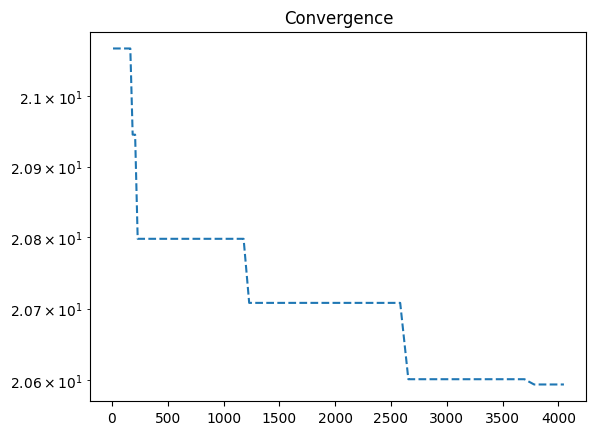

In [45]:
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.indicators.gd import GD
from pymoo.indicators.igd import IGD
import matplotlib.pyplot as plt
import numpy as np
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.termination import get_termination
from random import randint
from pymoo.termination.ftol import SingleObjectiveSpaceTermination
from pymoo.termination.robust import RobustTermination
from pymoo.termination.default import DefaultMultiObjectiveTermination

algorithm3 = BayesianOptimiztion()
res = minimize( get_problem("ackley", n_var=20, a=20, b=1/5, c=2 * np.pi),
                algorithm3,
                save_history=True,
                termination=('n_eval', 4000),
                seed = 1,
                
                verbose=True)

pf = get_problem("Rastrigin", n_var=2).pareto_front()
print("PF",pf[0])
ind = GD(pf)
print("GD", ind(res.F))
ind2 = IGD(pf)
print("IGD", ind2(res.F))


n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])
print(opt)
plt.title("Convergence")
plt.plot(n_evals, opt, "--")
plt.plot(n_evals, np.repeat(pf[0],len(n_evals)), 'k-', lw=1,dashes=[2, 2])
plt.yscale("log")
plt.show()

In [20]:
model = GaussianProcessRegressor()
model.fit([[ -5.4380459   ,14.439186  ],
 [-32.76050433 ,-12.95433252],
 [-23.15020594 ,-26.71649785],
 [-20.56125079 ,-10.12133219],
 [ -6.76544681  , 2.54389348],
 [ -5.2956683   ,12.13854518],
 [-19.36901736  ,24.78030431],
 [-30.97312669  ,11.17175875],
 [ -5.41951247  , 3.8462966 ],
 [-23.56760159 ,-19.78522081]], [[20.06610928],
 [20.91157246],
 [21.37552947],
 [21.03260106],
 [14.87330739],
 [18.44667829],
 [21.70183449],
 [20.45546651],
 [14.04636827],
 [21.75295851]])
model.predict([[-20  ,6.44 ]])

array([[2.00627112e-30]])

In [15]:
np.array([234,25]).reshape(1, -1)

array([[234,  25]])

In [47]:
res.X

array([-32.19226691, -22.7190659 ,  -0.04178701,  -8.33719612,
         5.50742679,  26.95829107,  21.69531855,  12.14126663,
       -22.20373865,  -7.23134422,  -0.78788617,   4.94442926,
        17.24182016, -10.24554162,   4.19786184,  11.80529107,
         8.82176719,   3.00087212,  30.91690694,  15.96978101])

[INFO-bo_w_gp-06/27/2023-16:20:12] range_X:
[[-32.768, 32.768],
[-32.768, 32.768],
[-32.768, 32.768]]
[INFO-bo_w_gp-06/27/2023-16:20:12] str_cov: matern52
[INFO-bo_w_gp-06/27/2023-16:20:12] str_acq: ei
[INFO-bo_w_gp-06/27/2023-16:20:12] str_optimizer_method_gp: BFGS
[INFO-bo_w_gp-06/27/2023-16:20:12] str_optimizer_method_bo: L-BFGS-B
[INFO-bo_w_gp-06/27/2023-16:20:12] str_modelselection_method: ml
[INFO-bo_w_gp-06/27/2023-16:20:12] num_init: 5
[INFO-bo_w_gp-06/27/2023-16:20:12] num_iter: 10
[INFO-bo_w_gp-06/27/2023-16:20:12] str_initial_method_bo: gaussian
[INFO-bo_w_gp-06/27/2023-16:20:12] str_sampling_method_ao: gaussian
[INFO-bo_w_gp-06/27/2023-16:20:12] num_samples_ao: 100
[INFO-bo_w_gp-06/27/2023-16:20:12] str_mlm_method: regular
[INFO-bo_w_gp-06/27/2023-16:20:12] seed: 42
[DEBUG-bo_w_gp-06/27/2023-16:20:12] samples:
[[8.138, -2.265, 10.612],
[24.953, -3.836, -3.836],
[25.874, 12.574, -7.692],
[8.889, -7.593, -7.631],
[3.964, -31.347, -28.261]]
[DEBUG-bo_w_gp-06/27/2023-16:20:12] 

[DEBUG-gp_kernel-06/27/2023-16:20:13] hyps optimized: {'noise': 0.010, 'signal': 6.644, 'lengthscales': [1.000, 1.000, 1.000]}
[DEBUG-gp_kernel-06/27/2023-16:20:13] time consumed to construct gpr: 0.0098 sec.
[DEBUG-bo_w_gp-06/27/2023-16:20:13] samples:
[[27.703, -32.768, 5.355],
[18.358, -5.024, 2.566],
[-9.525, -11.073, 18.370],
[-3.423, 24.887, -3.863],
[-23.404, 1.656, -13.745],
[3.199, 6.199, -14.638],
[-29.484, 15.408, 13.776],
[12.242, -21.186, -0.522],
[7.131, 6.659, -0.053],
[9.806, 26.546, 8.000],
[6.865, 15.362, -12.496],
[1.501, 17.431, 12.218],
[24.396, -1.583, -3.304],
[-28.712, -32.768, -6.732],
[-1.635, 25.258, 4.619],
[1.475, 5.097, 3.509],
[-12.573, -1.193, -4.026],
[27.371, -2.282, 15.148],
[18.080, -17.696, 0.281],
[-15.389, -1.973, 2.286],
[-1.466, -21.747, -0.422],
[2.275, 7.681, 20.036],
[-11.067, -13.676, 8.125],
[4.042, -21.502, -20.295],
[18.103, 3.600, -18.292],
[16.897, -12.451, -17.392],
[-24.478, 2.639, 26.257],
[-9.980, -28.460, 7.004],
[24.216, -18.885, 

BO Round 1


[DEBUG-bo_w_gp-06/27/2023-16:20:13] acquired sample: [24.216, -18.885, 4.403]
[DEBUG-bo_w_gp-06/27/2023-16:20:13] acquired sample: [14.426, -2.210, -4.674]
[DEBUG-bo_w_gp-06/27/2023-16:20:13] acquired sample: [6.704, -9.952, -30.990]
[DEBUG-bo_w_gp-06/27/2023-16:20:13] acquired sample: [-1.317, -4.972, 3.680]
[DEBUG-bo_w_gp-06/27/2023-16:20:13] acquired sample: [-24.226, -15.462, -32.768]
[DEBUG-bo_w_gp-06/27/2023-16:20:13] acquired sample: [-9.086, 3.891, -12.718]
[DEBUG-bo_w_gp-06/27/2023-16:20:13] acquired sample: [-24.415, -17.929, 3.888]
[DEBUG-bo_w_gp-06/27/2023-16:20:13] acquired sample: [7.473, 7.666, 3.763]
[DEBUG-bo_w_gp-06/27/2023-16:20:13] acquired sample: [19.481, -2.735, -12.254]
[DEBUG-bo_w_gp-06/27/2023-16:20:13] acquired sample: [-5.031, -9.573, 7.836]
[DEBUG-bo_w_gp-06/27/2023-16:20:13] acquired sample: [-10.528, 7.294, 7.799]
[DEBUG-bo_w_gp-06/27/2023-16:20:13] acquired sample: [32.768, -4.549, -5.368]
[DEBUG-bo_w_gp-06/27/2023-16:20:13] acquired sample: [32.768, 24.

[[  8.13816468  -2.26532231  10.61172901]
 [ 24.95332117  -3.83636889  -3.8360999 ]
 [ 25.87382277  12.5736506   -7.69186834]
 [  8.88930375  -7.59263548  -7.63051628]
 [  3.96430986 -31.34718353 -28.26105377]
 [ 27.70251546 -32.768        5.35476935]
 [ 16.45364202  32.768        9.8886135 ]
 [ -6.4759701  -11.87195905   6.36668912]
 [  1.84927473   9.50685505 -15.38269843]
 [-22.29243532  -0.82686715  30.75525323]
 [ -0.05166978  24.23530313  -0.43751111]
 [-28.00789652  -4.23161135 -24.0638182 ]
 [ 16.21329511  -0.25646544 -30.76786934]
 [-29.35481526  -6.77498867  -2.3725228 ]
 [-22.27682691  10.85361212   8.48634601]]
[[17.6101373 ]
 [19.72968859]
 [21.2435395 ]
 [17.94969458]
 [21.45150567]
 [21.8148374 ]
 [21.4954178 ]
 [18.43309791]
 [19.58629544]
 [21.38845768]
 [20.46131169]
 [20.47424162]
 [21.25259534]
 [21.42673323]
 [20.91640384]]
[0.         0.         0.         0.         0.         0.60434437
 0.72647882 0.43135238 0.47083354 0.48337436 0.54936147 0.56522202
 0.593787

[DEBUG-bo_w_gp-06/27/2023-16:20:18] acquired sample: [-4.395, -1.707, -6.690]
[DEBUG-bo_w_gp-06/27/2023-16:20:18] acquired sample: [7.753, -6.199, -22.000]
[DEBUG-bo_w_gp-06/27/2023-16:20:18] acquired sample: [-16.638, 16.145, 17.180]
[DEBUG-bo_w_gp-06/27/2023-16:20:18] acquired sample: [5.205, 12.075, 15.516]
[DEBUG-bo_w_gp-06/27/2023-16:20:18] acquired sample: [5.030, -1.969, -1.051]
[DEBUG-bo_w_gp-06/27/2023-16:20:18] acquired sample: [18.672, 7.888, 24.802]
[DEBUG-bo_w_gp-06/27/2023-16:20:18] acquired sample: [6.321, -6.923, 12.812]
[DEBUG-bo_w_gp-06/27/2023-16:20:18] acquired sample: [4.164, -12.683, -4.687]
[DEBUG-bo_w_gp-06/27/2023-16:20:18] acquired sample: [2.948, 0.637, -17.037]
[DEBUG-bo_w_gp-06/27/2023-16:20:18] acquired sample: [2.205, -10.159, -0.228]
[DEBUG-bo_w_gp-06/27/2023-16:20:18] acquired sample: [4.352, 14.606, 14.908]
[DEBUG-bo_w_gp-06/27/2023-16:20:18] acquired sample: [20.290, -18.284, 8.999]
[DEBUG-bo_w_gp-06/27/2023-16:20:18] acquired sample: [3.740, 16.184, 

[[ -2.15633432  -7.54396468  10.86197046]
 [-21.78495685  -8.89067243 -12.00736707]
 [-16.92975294  -3.74405439  -0.68422134]
 [-30.54567332   8.07893751  32.768     ]
 [-19.13716329   6.74141902  16.65841251]
 [ -1.47901961  -0.17625396  32.768     ]
 [  7.02071949 -18.1216779   32.768     ]
 [  8.52553734 -21.95345266  -4.85434081]
 [-28.82447073 -17.68317657  10.76881775]
 [ 25.52808292  -0.99349956   9.66062434]
 [-27.79207053  16.1054232  -21.344816  ]
 [  2.76116637   4.76517314   9.64658277]
 [ -4.29215808  32.768       29.09885393]
 [  3.72630367  15.05406226 -13.32845768]
 [  8.52925932 -32.768       17.87593725]]
[[17.37826781]
 [19.83009019]
 [18.85376793]
 [21.60283041]
 [20.73546654]
 [21.39926847]
 [20.63447802]
 [20.25996586]
 [21.3309049 ]
 [21.02304526]
 [21.30857265]
 [16.30853787]
 [21.34658402]
 [19.71917243]
 [21.52952137]]
[0.         0.         0.         0.         0.         0.51123524
 0.44163966 0.52701116 0.6270349  0.677423   0.55904484 0.59370732
 0.662609

[DEBUG-bo_w_gp-06/27/2023-16:20:24] acquired sample: [-10.855, 9.312, 32.768]
[DEBUG-bo_w_gp-06/27/2023-16:20:24] acquired sample: [18.861, 27.206, 1.184]
[DEBUG-bo_w_gp-06/27/2023-16:20:24] acquired sample: [-0.013, 17.817, -22.994]
[DEBUG-bo_w_gp-06/27/2023-16:20:24] acquired sample: [-5.919, 12.580, -32.768]
[DEBUG-bo_w_gp-06/27/2023-16:20:24] acquired sample: [-13.082, 11.268, -6.000]
[DEBUG-bo_w_gp-06/27/2023-16:20:24] acquired sample: [-9.612, 2.273, -31.379]
[DEBUG-bo_w_gp-06/27/2023-16:20:24] acquired sample: [3.635, -5.903, -0.208]
[DEBUG-bo_w_gp-06/27/2023-16:20:24] acquired sample: [2.295, 21.314, 2.605]
[DEBUG-bo_w_gp-06/27/2023-16:20:24] acquired sample: [11.021, 13.031, 3.457]
[DEBUG-bo_w_gp-06/27/2023-16:20:24] acquired sample: [-16.242, 9.438, 0.140]
[DEBUG-bo_w_gp-06/27/2023-16:20:24] acquired sample: [-7.719, -14.703, -8.890]
[DEBUG-bo_w_gp-06/27/2023-16:20:24] acquired sample: [-26.532, 32.768, 4.299]
[DEBUG-bo_w_gp-06/27/2023-16:20:24] acquired sample: [6.488, -1.47

[[-10.85121178  22.98457883  -9.6665409 ]
 [  1.7194538    1.31745204 -32.768     ]
 [  8.50435072   8.28700597   3.23520748]
 [ -1.17306955  23.87788524 -32.06818448]
 [ 24.76996817  -0.43130209 -12.41892878]
 [  6.68940193  31.81082175  -0.5759252 ]
 [-10.948112     1.32669256  10.62150973]
 [-16.65486523 -11.99635571 -32.768     ]
 [  5.12890738 -24.27663576  17.18128383]
 [ -2.70130355  -4.6101727   -9.69201343]
 [  6.86160695  14.48655973 -15.61612292]
 [-13.15406882 -26.42026498  -0.11117736]
 [ 15.80984211 -32.768      -31.88908377]
 [-19.43957774  -4.69973698  31.00099383]
 [  0.57695531 -26.94188942 -16.8449883 ]]
[[20.41522561]
 [21.41771109]
 [17.20484005]
 [20.51109885]
 [21.32722128]
 [21.50583885]
 [18.38125403]
 [21.2869878 ]
 [20.73653873]
 [16.52470597]
 [20.51514816]
 [20.89212056]
 [21.12798862]
 [21.51252566]
 [20.98276889]]
[0.         0.         0.         0.         0.         0.60073543
 0.51439118 0.51795554 0.49125242 0.59206247 0.56616306 0.70716453
 1.192795

[DEBUG-bo_w_gp-06/27/2023-16:20:31] acquired sample: [-12.542, 6.287, 11.920]
[DEBUG-bo_w_gp-06/27/2023-16:20:31] acquired sample: [-3.697, -9.657, 5.724]
[DEBUG-bo_w_gp-06/27/2023-16:20:31] acquired sample: [-7.172, 13.175, 22.171]
[DEBUG-bo_w_gp-06/27/2023-16:20:31] acquired sample: [-11.940, 1.849, -6.697]
[DEBUG-bo_w_gp-06/27/2023-16:20:31] acquired sample: [-12.355, -7.963, 3.934]
[DEBUG-bo_w_gp-06/27/2023-16:20:31] acquired sample: [5.907, 18.366, 21.387]
[DEBUG-bo_w_gp-06/27/2023-16:20:31] acquired sample: [17.973, -10.781, 32.453]
[DEBUG-bo_w_gp-06/27/2023-16:20:31] acquired sample: [8.933, -19.212, 20.540]
[DEBUG-bo_w_gp-06/27/2023-16:20:31] acquired sample: [-11.691, -7.306, -13.128]
[DEBUG-bo_w_gp-06/27/2023-16:20:31] acquired sample: [-2.202, -5.779, -10.220]
[DEBUG-bo_w_gp-06/27/2023-16:20:31] acquired sample: [-5.419, 10.540, 10.595]
[DEBUG-bo_w_gp-06/27/2023-16:20:31] acquired sample: [19.432, -2.590, 24.741]
[DEBUG-bo_w_gp-06/27/2023-16:20:31] acquired sample: [-17.635,

[[  8.66638123  32.768      -12.61650521]
 [-19.65547393   6.93785153  15.87253865]
 [  1.44060752  28.54090095  23.92509012]
 [ -9.32979948 -25.10454359  32.768     ]
 [ -4.51448062  22.72749591  -9.964646  ]
 [  9.92480551   9.93175087   6.04202975]
 [ 15.30766147   7.09988831 -23.68754826]
 [-32.768       -8.96913038   1.25109779]
 [ 25.46983288  -3.97251007  -9.36867433]
 [ -4.52889196  -9.10788974  19.45357877]
 [-15.82569001   3.31603044  -5.98837453]
 [ -1.69073132 -24.00483309 -14.74845106]
 [ -7.37493792  20.32602665 -32.768     ]
 [ 26.07964237  -9.76150662  24.43817887]
 [-23.67076754  26.76808872  -4.29114722]]
[[21.72556606]
 [20.32299381]
 [21.73303951]
 [21.41551055]
 [20.68388999]
 [16.78094241]
 [20.99785645]
 [20.88688351]
 [21.07732365]
 [20.45402833]
 [18.56707226]
 [20.71776988]
 [21.79954983]
 [21.43282959]
 [21.59144014]]
[0.         0.00100017 0.         0.         0.         0.42907524
 0.41600585 0.45001411 0.56225038 0.52199626 0.48064017 0.45401788
 0.498340

[DEBUG-bo_w_gp-06/27/2023-16:20:36] acquired sample: [-1.515, -32.768, -13.703]
[DEBUG-bo_w_gp-06/27/2023-16:20:36] acquired sample: [15.658, -32.256, 4.294]
[DEBUG-bo_w_gp-06/27/2023-16:20:36] acquired sample: [5.163, 6.027, 23.509]
[DEBUG-bo_w_gp-06/27/2023-16:20:36] acquired sample: [-32.768, -32.768, -13.162]
[DEBUG-bo_w_gp-06/27/2023-16:20:36] acquired sample: [20.718, 20.418, 32.768]
[DEBUG-bo_w_gp-06/27/2023-16:20:36] acquired sample: [14.173, -0.186, 29.617]
[DEBUG-bo_w_gp-06/27/2023-16:20:36] acquired sample: [5.348, -3.488, 32.768]
[DEBUG-bo_w_gp-06/27/2023-16:20:36] acquired sample: [3.675, -13.806, -18.664]
[DEBUG-bo_w_gp-06/27/2023-16:20:36] acquired sample: [1.842, 0.821, 2.027]
[DEBUG-bo_w_gp-06/27/2023-16:20:36] acquired sample: [-19.226, -10.604, -2.529]
[DEBUG-bo_w_gp-06/27/2023-16:20:36] acquired sample: [-18.128, -4.888, -2.864]
[DEBUG-bo_w_gp-06/27/2023-16:20:36] acquired sample: [-24.272, 16.944, 20.440]
[DEBUG-bo_w_gp-06/27/2023-16:20:36] acquired sample: [-4.274

[[ -4.89597583  -9.93529049   0.38245207]
 [ 24.71093747  23.95268333  -9.816874  ]
 [ 16.79716253   2.71709764 -12.74456581]
 [-10.46580104   7.14223204   5.93692099]
 [-10.74254967  -6.36569747  14.97069501]
 [  3.4724156  -25.43303135  28.611704  ]
 [-16.44806796 -11.76282923 -24.22775324]
 [ 11.91252016   8.44942757  15.07449844]
 [-23.55389598  32.768        3.3162592 ]
 [ -7.4376591   29.27334636  22.16289938]
 [-31.59522137   6.35653579 -20.43307753]
 [ -6.41613413 -22.44478854   4.69604238]
 [  1.39427717 -23.18341481 -25.87372149]
 [  8.80269755  -3.76074132  32.768     ]
 [ 19.20091738  30.59787671  14.9750677 ]]
[[15.77291185]
 [20.94429373]
 [19.98297268]
 [17.53326417]
 [19.51773826]
 [22.07018086]
 [21.41062069]
 [19.64274036]
 [21.86926457]
 [21.62135114]
 [22.01887506]
 [20.94866461]
 [21.24465313]
 [21.14655888]
 [21.32813494]]
[0.00099921 0.         0.         0.         0.         0.50946212
 0.4679966  0.41816688 0.45260406 0.45500994 0.45502663 0.53104591
 0.571743

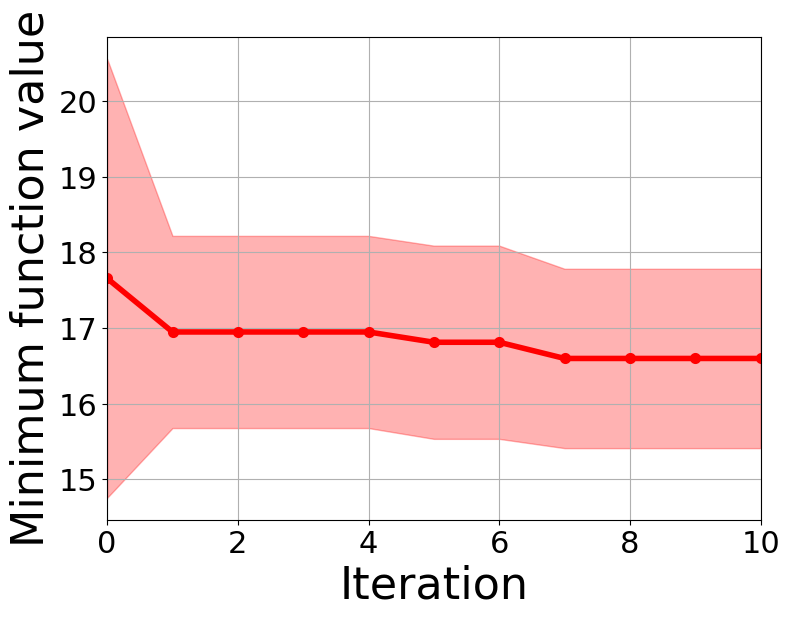

<Figure size 300x200 with 0 Axes>

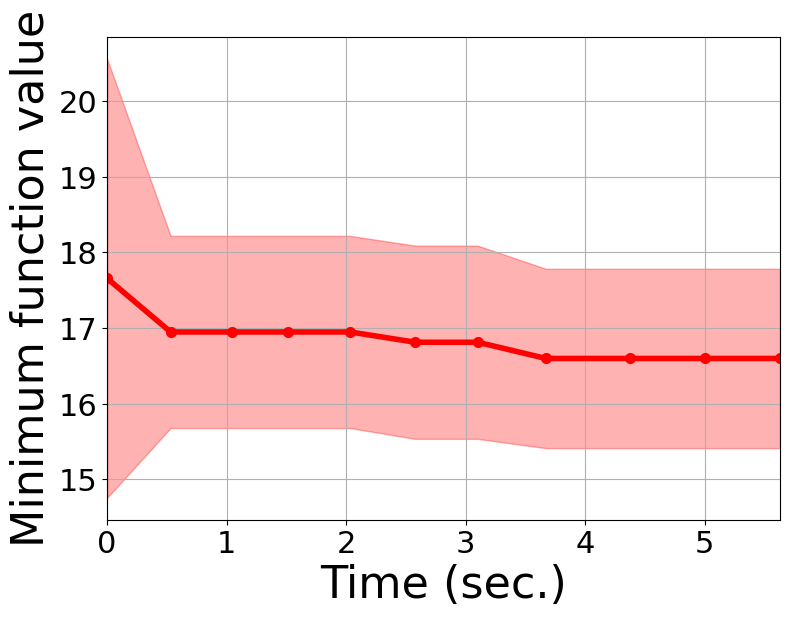

<Figure size 300x200 with 0 Axes>

In [39]:
import numpy as np
import os

from bayeso import bo
from bayeso_benchmarks import Ackley
from bayeso import wrappers
from bayeso.utils import utils_bo
from bayeso.utils import utils_plotting


STR_FUN_TARGET = 'ackley'
PATH_SAVE = '../figures/benchmarks/'
NUM_DIM = 3

obj_fun = Ackley(NUM_DIM)

def fun_target(X):
    return obj_fun.output(X)

def main():
    num_bo = 5
    num_iter = 10
    num_init = 5

    bounds = obj_fun.get_bounds()
    model_bo = bo.BO(bounds, debug=True)
    list_Y = []
    list_time = []
    for ind_bo in range(0, num_bo):
        print('BO Round', ind_bo + 1)
        X_final, Y_final, time_final, _, _ = wrappers.run_single_round(model_bo, fun_target, num_init, num_iter, str_initial_method_bo='gaussian', str_sampling_method_ao='gaussian', num_samples_ao=100, seed=42 * (ind_bo + 1))
        print(X_final)
        print(Y_final)
        print(time_final)
        list_Y.append(Y_final)
        list_time.append(time_final)

        bx_best, y_best = utils_bo.get_best_acquisition_by_history(X_final, Y_final)
        print(bx_best, y_best)

    arr_Y = np.array(list_Y)
    arr_Y = np.expand_dims(np.squeeze(arr_Y), axis=0)
    arr_time = np.array(list_time)
    arr_time = np.expand_dims(arr_time, axis=0)
    utils_plotting.plot_minimum_vs_iter(arr_Y, [STR_FUN_TARGET], num_init, True, path_save=PATH_SAVE, str_postfix=STR_FUN_TARGET)
    utils_plotting.plot_minimum_vs_time(arr_time, arr_Y, [STR_FUN_TARGET], num_init, True, path_save=PATH_SAVE, str_postfix=STR_FUN_TARGET)


if __name__ == '__main__':
    if not os.path.isdir(PATH_SAVE):
        os.makedirs(PATH_SAVE)
    main()